### MLP 

Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

Custom dataset 
(https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
(https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [2]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Stele dataset w/o transformations

0 torch.Size([1, 256, 265]) 0
1 torch.Size([1, 256, 265]) 0
2 torch.Size([1, 256, 265]) 0
3 torch.Size([1, 256, 265]) 0


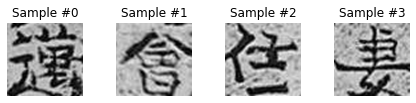

In [12]:
stele_dataset = CustomImageDataset(annotations_file='D:\\UniMSc\\MA\\data\\STELES\\lbls.csv',img_dir='D:\\UniMSc\\MA\\data\\STELES\\imgs\\')

fig = plt.figure()

for i in range(len(stele_dataset)):
    image, label = stele_dataset[i]

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(image.permute(1, 2, 0), cmap='gray')

    if i == 3:
        plt.show()
        break

Rescale images

In [20]:
from skimage import io, transform

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample
        image = image.permute(1, 2, 0)
#         h, w = image.shape[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size

#         new_h, new_w = int(new_h), int(new_w)

#         img = transform.resize(image, (new_h, new_w))
        img = transform.resize(image, (self.output_size, self.output_size))

        return img


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image).float()

Visualise rescaled sample image

<Figure size 432x288 with 0 Axes>

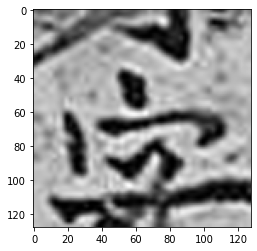

In [21]:
composed = transforms.Compose([Rescale(128), ToTensor()])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = stele_dataset[65]
image, label = sample
transformed_sample = composed(image)

plt.figure()
plt.imshow(transformed_sample.permute(1, 2, 0), cmap='gray') 
plt.show() 

plt.show()

Stele dataset with transformations

In [63]:
transformed_dataset = CustomImageDataset(annotations_file='D:\\UniMSc\\MA\\data\\STELES\\lbls.csv',
                                         img_dir='D:\\UniMSc\\MA\\data\\STELES\\imgs\\',
                                         transform=transforms.Compose([
#                                                transforms.Grayscale(num_output_channels=1),
                                               Rescale(64),
                                               ToTensor()
                                           ]))

Visualise transformed stele dataset sample

0 torch.Size([1, 128, 128]) 0
1 torch.Size([1, 128, 128]) 0
2 torch.Size([1, 128, 128]) 0
3 torch.Size([1, 128, 128]) 0


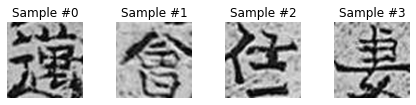

In [53]:
fig = plt.figure()

for i in range(len(transformed_dataset)):
    image, label = transformed_dataset[i]

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(image.permute(1, 2, 0), cmap='gray')

    if i == 3:
        plt.show()
        break

Data Preparation

In [64]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2# convert data to torch.FloatTensor
test_size = 0.1
# transform = transforms.ToTensor()# choose the training and testing datasets
# train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)# obtain training indices that will be used for validation
num_train = len(transformed_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
train_index, valid_index = indices[valid_split:], indices[:valid_split]# define samplers for obtaining training and validation batches
train_index, test_index = indices[test_split:], indices[:test_split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
test_sampler = SubsetRandomSampler(test_index)
train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size,
                                         sampler = test_sampler, num_workers = num_workers)

In [55]:
# print(train_data[0])
print(transformed_dataset[0])

(tensor([[[0.7029, 0.7000, 0.6994,  ..., 0.6038, 0.6282, 0.6440],
         [0.6804, 0.6859, 0.6961,  ..., 0.6032, 0.6215, 0.6323],
         [0.6412, 0.6593, 0.6890,  ..., 0.6019, 0.6106, 0.6157],
         ...,
         [0.2959, 0.2429, 0.1466,  ..., 0.4366, 0.4337, 0.4333],
         [0.3724, 0.3288, 0.2506,  ..., 0.5434, 0.4751, 0.4403],
         [0.4195, 0.3814, 0.3140,  ..., 0.6030, 0.4995, 0.4413]]]), 0)


Network architecture

In [65]:
import torch.nn as nn
import torch.nn.functional as F# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(64*64, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,5)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,64*64)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


Loss function and optimiser

In [58]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

CUDA

In [59]:
# check if CUDA is available (to increase performance)
cuda = False
if torch.cuda.is_available():
    cuda = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training

In [66]:
# number of epochs to train the model
n_epochs = 50# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        if cuda:
            model.to(device)
            data, label = data.to(device), label.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        if cuda:
            model.to(device)
            data, label = data.to(device), label.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.612662 	Validation Loss: 0.013639
Validation loss decreased (inf --> 0.013639).  Saving model ...
Epoch: 2 	Training Loss: 1.611143 	Validation Loss: 0.012949
Validation loss decreased (0.013639 --> 0.012949).  Saving model ...
Epoch: 3 	Training Loss: 1.612309 	Validation Loss: 0.012955
Epoch: 4 	Training Loss: 1.612388 	Validation Loss: 0.013092
Epoch: 5 	Training Loss: 1.612471 	Validation Loss: 0.013721
Epoch: 6 	Training Loss: 1.613730 	Validation Loss: 0.013001
Epoch: 7 	Training Loss: 1.611520 	Validation Loss: 0.013111
Epoch: 8 	Training Loss: 1.612397 	Validation Loss: 0.013352
Epoch: 9 	Training Loss: 1.610637 	Validation Loss: 0.013380
Epoch: 10 	Training Loss: 1.614076 	Validation Loss: 0.013123
Epoch: 11 	Training Loss: 1.612402 	Validation Loss: 0.013367
Epoch: 12 	Training Loss: 1.611432 	Validation Loss: 0.013432
Epoch: 13 	Training Loss: 1.612426 	Validation Loss: 0.013517
Epoch: 14 	Training Loss: 1.612267 	Validation Loss: 0.013357
Epoch: 1

Load best model

In [67]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

Test network

In [68]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if cuda:
            model.to(device)
            data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item() if len(target) > 1 else correct.item()
        class_total[label] += 1
    
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.609740

Test Accuracy of     0:  0% ( 0/30)
Test Accuracy of     1: 69% (32/46)
Test Accuracy of     2:  0% ( 0/33)
Test Accuracy of     3:  0% ( 0/40)
Test Accuracy of     4: 18% ( 6/32)

Test Accuracy (Overall): 20% (38/181)


Visualise test results

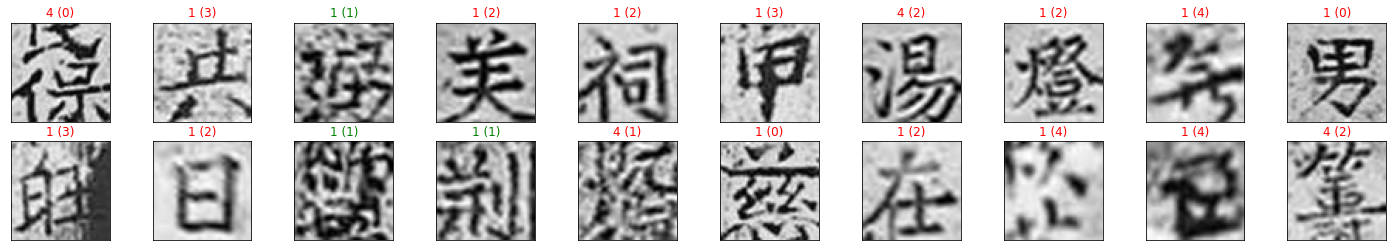

In [70]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()# get sample outputs
if cuda:
    model.to(device)
    images, labels = images.to(device), labels.to(device)
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))